In [58]:
import json
import pandas as pd
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from IPython.display import Image, display
%matplotlib inline
sns.set_style("whitegrid")

# import local modules
import getpbp
import getdata as gd
from BasketballCourt import get_layout

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',  None)
%load_ext autoreload
%autoreload 2
import math
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'notebook'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load and review raw data**

In [59]:
files = []
for file in os.listdir('../data'):
    files.append(file)

In [60]:
# Get game ids of all 18 games
game_files = files[:-3]
game_ids = []
for game in game_files:
    game_id = game.split('_')[0]
    game_ids.append(game_id)
game_ids = list(set(game_ids))
print(game_ids)

['0042100402', '0042100406', '0042100303', '0042100403', '0042100313', '0042100302', '0042100306', '0042100305', '0042100312', '0042100307', '0042100314', '0042100315', '0042100301', '0042100401', '0042100404', '0042100405', '0042100304', '0042100311']


In [61]:
def load_json_file(file_path):
    '''
    Load JSON data
    '''
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [62]:
def load_jsonl_file(file_path):
    '''
    Load JSONL data
    '''
    with jsonlines.open(file_path) as reader:
        return list(reader)

In [63]:
# Load and review the player info data
players = load_json_file('../data/metadata_players.json')
players_df = pd.DataFrame(players['players'])
print(players_df.shape)
players_df.head()

(1533, 8)


,id,firstName,lastName,nbaId,height,weight,dob,position
0,ff415697-89ef-11e6-a31e-a45e60e298d3,Aaron,Brooks,201166,72.0,161.0,1985-01-14,G
1,ff42ec5e-89ef-11e6-96c8-a45e60e298d3,Aaron,Gordon,203932,80.0,235.0,1995-09-16,F
2,ff4020d4-89ef-11e6-af09-a45e60e298d3,Aaron,Gray,201189,84.0,270.0,1984-12-07,C
3,ff4199f8-89ef-11e6-854d-a45e60e298d3,Aaron,Harrison,1626151,78.0,210.0,1994-10-28,G
4,c9b3e617-4bd6-4399-970f-b84358a6783f,Aaron,Henry,1630565,77.0,210.0,1999-08-30,F


In [64]:
players_df['position'].value_counts()

position
G      589
F      450
C      135
G-F    112
F-C     83
C-F     58
F-G     41
         9
Name: count, dtype: int64

In [65]:
# Load and review the metadata
metadata = load_json_file('../data/metadata.json')
metadata_df = pd.DataFrame(metadata['games'])

# Subset the metadata for the 18 games
metadata_df = metadata_df[metadata_df['nbaId'].isin(game_ids)]
# Combine separated date info
metadata_df['date'] = pd.to_datetime(metadata_df[['month', 'day', 'year']]).dt.strftime('%m-%d-%Y')

In [66]:
print(metadata_df.shape)
metadata_df.head()

(18, 15)


,id,homeTeamId,awayTeamId,nbaId,type,path,prefix,lastMod,completed,trackingState,season,year,month,day,date
1329,9f9f8793-d8c4-4e27-b2fc-432698b7bc50,feb4cb57-89ef-11e6-86b2-a45e60e298d3,feb4d0a6-89ef-11e6-82c6-a45e60e298d3,0042100406,playoff,2021-22/0042100406/,0042100406,2023-02-23T07:01:38.000Z,True,full,2021,2022,6,16,06-16-2022
1330,057c4fb6-9bbb-496b-8852-a763968da000,feb4d0a6-89ef-11e6-82c6-a45e60e298d3,feb4cb57-89ef-11e6-86b2-a45e60e298d3,0042100405,playoff,2021-22/0042100405/,0042100405,2023-02-23T06:52:19.000Z,True,full,2021,2022,6,13,06-13-2022
1331,d04fcb9c-22d1-4b70-af2d-2fe367b45d5a,feb4cb57-89ef-11e6-86b2-a45e60e298d3,feb4d0a6-89ef-11e6-82c6-a45e60e298d3,0042100404,playoff,2021-22/0042100404/,0042100404,2023-02-23T07:02:59.000Z,True,full,2021,2022,6,10,06-10-2022
1332,1706335e-b170-46ed-ac58-2a72715a6c86,feb4cb57-89ef-11e6-86b2-a45e60e298d3,feb4d0a6-89ef-11e6-82c6-a45e60e298d3,0042100403,playoff,2021-22/0042100403/,0042100403,2023-02-23T06:55:23.000Z,True,full,2021,2022,6,8,06-08-2022
1333,135d26c9-57f2-4e2e-a72c-e91e32d29957,feb4d0a6-89ef-11e6-82c6-a45e60e298d3,feb4cb57-89ef-11e6-86b2-a45e60e298d3,0042100402,playoff,2021-22/0042100402/,0042100402,2023-02-23T06:52:52.000Z,True,full,2021,2022,6,5,06-05-2022


In [67]:
# Load and review the team info data
teams = load_json_file('../data/metadata_teams.json')
teams_df = pd.DataFrame(teams['teams'])
print(teams_df.shape)
teams_df.head()

(56, 4)


,id,name,abbrev,nbaId
0,5c079629-763c-4098-ba62-424375967c9a,Adelaide 36ers,ADL,15019
1,feb3e09c-89ef-11e6-9f68-a45e60e298d3,Atlanta Hawks,ATL,1610612737
2,6964d06d-ab82-419c-8a16-0d8ff6a17f94,Beijing Ducks,BJD,15021
3,feb4cb57-89ef-11e6-86b2-a45e60e298d3,Boston Celtics,BOS,1610612738
4,feb4cc63-89ef-11e6-9333-a45e60e298d3,Brooklyn Nets,BKN,1610612751


In [68]:
# Load and review the event data of one game
event = load_jsonl_file('../data/0042100401_events.jsonl')
event_df = pd.DataFrame(event)
print(event_df.shape)
event_df.head()

(3647, 10)


,gameId,eventType,shotClock,gameClock,wallClock,period,homePlayers,awayPlayers,playerId,pbpId
0,bb74c0c9-a84e-4bee-9919-3e522be652ac,TOUCH,24.0,719.32,1654218554890,1,"[ff4179a1-89ef-11e6-909f-a45e60e298d3, ff41a31...","[ff411907-89ef-11e6-9c68-a45e60e298d3, 986b713...",ff411907-89ef-11e6-9c68-a45e60e298d3,NaN
1,bb74c0c9-a84e-4bee-9919-3e522be652ac,DRIBBLE,23.8,718.56,1654218555650,1,"[ff4179a1-89ef-11e6-909f-a45e60e298d3, ff41a31...","[ff411907-89ef-11e6-9c68-a45e60e298d3, 986b713...",ff411907-89ef-11e6-9c68-a45e60e298d3,NaN
2,bb74c0c9-a84e-4bee-9919-3e522be652ac,DRIBBLE,22.9,717.68,1654218556530,1,"[ff4179a1-89ef-11e6-909f-a45e60e298d3, ff41a31...","[ff411907-89ef-11e6-9c68-a45e60e298d3, 986b713...",ff411907-89ef-11e6-9c68-a45e60e298d3,NaN
3,bb74c0c9-a84e-4bee-9919-3e522be652ac,DRIBBLE,22.1,716.84,1654218557370,1,"[ff4179a1-89ef-11e6-909f-a45e60e298d3, ff41a31...","[ff411907-89ef-11e6-9c68-a45e60e298d3, 986b713...",ff411907-89ef-11e6-9c68-a45e60e298d3,NaN
4,bb74c0c9-a84e-4bee-9919-3e522be652ac,DRIBBLE,21.4,716.12,1654218558090,1,"[ff4179a1-89ef-11e6-909f-a45e60e298d3, ff41a31...","[ff411907-89ef-11e6-9c68-a45e60e298d3, 986b713...",ff411907-89ef-11e6-9c68-a45e60e298d3,NaN


In [69]:
# Load and review the tracking data of one game
tracking = load_jsonl_file('../data/0042100401_tracking.jsonl')
tracking_df = pd.DataFrame(tracking)
print(tracking_df.shape)
tracking_df.head()

(88800, 9)


,frameIdx,homePlayers,awayPlayers,ball,period,gameClock,gameClockStopped,shotClock,wallClock
0,102600,"[{'xyz': [-2.92, 7.25, 0], 'jersey': '11', 'pl...","[{'xyz': [1.08, -7.58, 0], 'jersey': '0', 'pla...","[0.23, 0.31, 6.44]",1,720.0,True,24.0,1654218552970
1,102601,"[{'xyz': [-2.92, 7.25, 0], 'jersey': '11', 'pl...","[{'xyz': [1.08, -7.58, 0], 'jersey': '0', 'pla...","[0.22, 0.3, 6.42]",1,720.0,True,24.0,1654218553010
2,102602,"[{'xyz': [-2.92, 7.25, 0], 'jersey': '11', 'pl...","[{'xyz': [1.08, -7.58, 0], 'jersey': '0', 'pla...","[0.2, 0.28, 6.4]",1,720.0,True,24.0,1654218553050
3,102603,"[{'xyz': [-2.92, 7.24, 0], 'jersey': '11', 'pl...","[{'xyz': [1.08, -7.58, 0], 'jersey': '0', 'pla...","[0.2, 0.25, 6.37]",1,720.0,True,24.0,1654218553090
4,102604,"[{'xyz': [-2.92, 7.24, 0], 'jersey': '11', 'pl...","[{'xyz': [1.08, -7.58, 0], 'jersey': '0', 'pla...","[0.19, 0.22, 6.35]",1,720.0,True,24.0,1654218553130


In [70]:
# Check if all the (period, gameClock) combo in event data exist in tracking data of the same game
def are_gameClocks_matching(event_file_path, tracking_file_path):
    '''
    Check if all (period, gameClocks) from the events file are present in the tracking file.
    
    Args: event_file_path(str)
          tracking_file_path(str)
    Return: True or False
    '''
    with jsonlines.open(event_file_path) as event_reader, jsonlines.open(tracking_file_path) as tracking_reader:
        event_gameClocks = {(event['period'], event['gameClock']) for event in event_reader}
        tracking_gameClocks = {(tracking['period'], tracking['gameClock']) for tracking in tracking_reader}

    return event_gameClocks.issubset(tracking_gameClocks)

for game in game_ids:
    event_file_path = '../data/' + game + '_events.jsonl'
    tracking_file_path = '../data/' + game + '_tracking.jsonl'

    if are_gameClocks_matching(event_file_path, tracking_file_path):
        print(f"All (period, gameClock) in {game} events are present in {game} tracking.")
    else:
        print(f"(period, gameClock) mismatch in {game} events and {game} tracking.")

All (period, gameClock) in 0042100402 events are present in 0042100402 tracking.
All (period, gameClock) in 0042100406 events are present in 0042100406 tracking.
All (period, gameClock) in 0042100303 events are present in 0042100303 tracking.
All (period, gameClock) in 0042100403 events are present in 0042100403 tracking.
All (period, gameClock) in 0042100313 events are present in 0042100313 tracking.
All (period, gameClock) in 0042100302 events are present in 0042100302 tracking.
All (period, gameClock) in 0042100306 events are present in 0042100306 tracking.
All (period, gameClock) in 0042100305 events are present in 0042100305 tracking.
All (period, gameClock) in 0042100312 events are present in 0042100312 tracking.
All (period, gameClock) in 0042100307 events are present in 0042100307 tracking.
All (period, gameClock) in 0042100314 events are present in 0042100314 tracking.
All (period, gameClock) in 0042100315 events are present in 0042100315 tracking.
All (period, gameClock) in 0

**Transform data**

- This tranformation generate infos related to each shot in the 18 games. Free throws are not included.

In [71]:
def get_unique_homeplayer_ids(jsonl_file_path):
    '''
    Get unique home player IDs from a JSONL file.
    
    Arg: jsonl_file_path(str)
    Return: A list of ids
    '''
    unique_homeplayer_ids = set()
    with jsonlines.open(jsonl_file_path) as reader:
        for item in reader:
            homeplayers = item.get('homePlayers', [])
            for player in homeplayers:
                unique_homeplayer_ids.add(player)
    return unique_homeplayer_ids

In [72]:
def get_unique_awayplayer_ids(jsonl_file_path):
    '''
    Get unique away player IDs from a JSONL file.
    
    Arg: jsonl_file_path(str)
    Return: A list of ids
    '''
    unique_awayplayer_ids = set()
    with jsonlines.open(jsonl_file_path) as reader:
        for item in reader:
            awayplayers = item.get('awayPlayers', [])
            for player in awayplayers:
                unique_awayplayer_ids.add(player)
    return unique_awayplayer_ids

In [73]:
# Generate a dict for application
game_dict = {}

# Get player ids of each game
home_player_dict = {}
away_player_dict = {}

# Get the set of all players played the 18 games
home_player_ids = set()
away_player_ids = set()

In [74]:
for game_id in game_ids:   
    eventpath = '../data/'+ game_id +'_events.jsonl'

    home_ids = get_unique_homeplayer_ids(eventpath)
    away_ids = get_unique_awayplayer_ids(eventpath)
    
    home_player_ids.update(home_ids)
    away_player_ids.update(away_ids)
    
    home_player_dict[game_id] = home_ids
    away_player_dict[game_id] = away_ids
    
    home_team = gd.get_homeTeam(game_id)
    away_team = gd.get_awayTeam(game_id)
    game_key = gd.get_date(game_id) + ' ' + home_team +' vs '+ away_team
    game_dict[game_key] = {'home_team':home_team, 'home_player':{}, 'away_team':away_team, 'away_player':{}}
    
    home_ids = list(home_ids)
    home_names = [gd.get_playerInfo(playerid, 'id', 'fullName') for playerid in home_ids]    
    game_dict[game_key]['home_player'] = home_names
    
    away_ids = list(away_ids)
    away_names = [gd.get_playerInfo(playerid, 'id', 'fullName') for playerid in away_ids]
    game_dict[game_key]['away_player'] = away_names
    
print(str(len(home_player_ids))+' players played in home teams')
print(str(len(away_player_ids))+' players played in away teams')

52 players played in home teams
55 players played in away teams


In [75]:
player_set = home_player_ids.union(away_player_ids)
print(len(player_set))

55


In [76]:
# Save game dict for application
with open('../new_data/game_dict.json', 'w') as json_file:
    json.dump(game_dict, json_file)

- Take player Jaylen Brown as an example to show the process of transformation

In [77]:
Jaylen_id = gd.get_playerInfo('Jaylen Brown', 'fullName', 'id')
Jaylen_game_ids = [key for key, value in home_player_dict.items() if Jaylen_id in value]
Jaylen_game_ids

['0042100406',
 '0042100303',
 '0042100403',
 '0042100306',
 '0042100404',
 '0042100304']

In [78]:
# Take one game as an example
game_0 = Jaylen_game_ids[0]

In [79]:
# Get play by play data 
Jaylen_shots_pbp = getpbp.get_shot(game_0, 'Jaylen Brown')

In [80]:
print(Jaylen_shots_pbp.shape)
Jaylen_shots_pbp.head()

(23, 5)


,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION
0,17,1,79,Brown 19' Pullup Jump Shot (2 PTS),None
1,27,1,1,Brown 28' 3PT Jump Shot (5 PTS) (Smart 1 AST),None
2,56,2,1,MISS Brown 26' 3PT Jump Shot,None
3,60,2,6,MISS Brown 5' Driving Layup,None
4,105,1,47,Brown 14' Turnaround Jump Shot (7 PTS) (Pritch...,None


In [81]:
# Separate 3 points shot and 2 points shot
Jaylen_shots_pbp['ACTIONTYPE'] = Jaylen_shots_pbp['HOMEDESCRIPTION'].apply(
    lambda x: '3PT' if ' 3PT ' in x else '2PT')

In [82]:
def load_event_shots(file_path, player_id):
    '''
    Get filtered event data from a JSONL file which matches specified player and eventType 'SHOT'.
    
    Arg: file_path(str)
         player_id(str)  
    Return: JSON dictionary
    '''
    with jsonlines.open(file_path) as reader:
        lines = iter(reader)
        prev_line = next(lines, None)
        filtered_data = []

        for line in lines:
            if line['eventType'] == 'SHOT' and line['playerId'] == player_id:

                filtered_data.append(prev_line)
                filtered_data.append(line)
            
            prev_line = line        
    return filtered_data

In [83]:
def get_event(game_id, player_id):
    
    '''
    Load the transform event data that matches specified game and player, replace part of the eventType values 
    to 'DRIBBLE SHOT', subset the dataframe.
    
    Args: game_id(str)
          player_id(str)
    Return: dataframe
    '''
    event_data =load_event_shots(f'../data/{game_id}_events.jsonl', player_id)
    player_event_df = pd.DataFrame(event_data)
    player_event_df['pbpId'] = player_event_df['pbpId'].astype('Int64')
    
    for i in range(1, len(player_event_df)):
        if player_event_df.loc[i, 'eventType'] == 'SHOT' and player_event_df.loc[i - 1, 'eventType'] == 'DRIBBLE':
            player_event_df.loc[i, 'eventType'] = 'DRIBBLE SHOT'
    player_event_df = player_event_df[(player_event_df['eventType'] == 'SHOT') | (
        player_event_df['eventType'] == 'DRIBBLE SHOT')]
    
    player_event_df.reset_index(drop=True, inplace = True)
    player_event_df = player_event_df[['eventType','gameClock','shotClock','period','pbpId']]
    return player_event_df

In [84]:
# Get events data
Jaylen_event = get_event(game_0, Jaylen_id)
print(Jaylen_event.shape)
Jaylen_event.head()

(25, 5)


,eventType,gameClock,shotClock,period,pbpId
0,DRIBBLE SHOT,653.52,17.8,1,17
1,SHOT,596.88,14.9,1,27
2,SHOT,454.24,12.5,1,56
3,DRIBBLE SHOT,417.88,8.3,1,60
4,SHOT,212.80,8.2,1,105


In [85]:
# Merge pbp data and event data, using pbp as 'how' to exclude free throws
Jaylen_merge = pd.merge(Jaylen_shots_pbp, Jaylen_event, left_on = 'EVENTNUM',
                        right_on = 'pbpId', how = 'left')
print(Jaylen_merge.shape)

(23, 11)


In [86]:
# Get location data from the tracking data
Jaylen_xy = gd.get_xy_df(game_0, Jaylen_id)

In [87]:
print(Jaylen_xy.shape)
Jaylen_xy.head()

(65466, 4)


,period,gameClock,x,y
70,1,720.00,1.25,7.83
71,1,719.96,1.34,7.80
72,1,719.92,1.43,7.77
73,1,719.88,1.51,7.74
74,1,719.84,1.59,7.70


In [88]:
# Merge previous dataframe and location data
Jaylen_merge = pd.merge(Jaylen_merge, Jaylen_xy, on = ['gameClock', 'period'], how = 'left')
print(Jaylen_merge.shape)
Jaylen_merge.head()

(23, 13)


,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,ACTIONTYPE,eventType,gameClock,shotClock,period,pbpId,x,y
0,17,1,79,Brown 19' Pullup Jump Shot (2 PTS),None,2PT,DRIBBLE SHOT,653.52,17.8,1,17,-27.77,13.61
1,27,1,1,Brown 28' 3PT Jump Shot (5 PTS) (Smart 1 AST),None,3PT,SHOT,596.88,14.9,1,27,-14.59,4.77
2,56,2,1,MISS Brown 26' 3PT Jump Shot,None,3PT,SHOT,454.24,12.5,1,56,-29.31,21.50
3,60,2,6,MISS Brown 5' Driving Layup,None,2PT,DRIBBLE SHOT,417.88,8.3,1,60,-39.38,-4.68
4,105,1,47,Brown 14' Turnaround Jump Shot (7 PTS) (Pritch...,None,2PT,SHOT,212.80,8.2,1,105,-41.31,-18.16


In [89]:
def process_data(json_data, df):
    '''
    Load data from JSON file that matches specified dataframe on both 'gameClock' and 'period'.
    
    Args: Json_data(JSON item)
          df(dataframe)
    
    Return: JSON dictionary or None
    '''
    unique_tuples = set(zip(df['gameClock'], df['period']))
    if (json_data['gameClock'], json_data['period']) in unique_tuples:
        return json_data
    else:
        return None

def filter_data_from_jsonl(file_path, df):
    '''
    Load data from JSON file that matches specified dataframe on both 'gameClock' and 'period',
    using function 'process_data'.
    
    Args: file_path(str)
          df(dataframe)
    
    Return: JSON dictionary
    '''    
    with jsonlines.open(file_path) as reader:
        for item in reader:
            filtered_item = process_data(item, df)
            if filtered_item:
                yield filtered_item

In [90]:
def get_tracking_shots(game, df):
    '''
    Load data from JSON file that matches specified game
    
    Args: game(str): game id
    df(dataframe)
    Return: dataframe
    '''
    file_path = '../data/'+game+'_tracking.jsonl'
    df = pd.DataFrame(filter_data_from_jsonl(file_path, df))
    df.drop_duplicates(subset=['gameClock', 'period'], keep='first', inplace=True)
    return df

In [91]:
# Get opponents location info for shot events
game_tracking = get_tracking_shots(game_0, Jaylen_merge)
print(game_tracking.shape)
game_tracking.head()

(23, 9)


,frameIdx,homePlayers,awayPlayers,ball,period,gameClock,gameClockStopped,shotClock,wallClock
0,103089,"[{'xyz': [-11.45, -2.99, 0], 'jersey': '0', 'p...","[{'xyz': [-40.57, -9.17, 0], 'jersey': '11', '...","[-28.73, 12.52, 9.81]",1,653.52,False,17.76,1655428185206
1,104894,"[{'xyz': [-18.78, -14.17, 0], 'jersey': '0', '...","[{'xyz': [-20.75, 4.75, 0], 'jersey': '11', 'p...","[-15.73, 4.52, 9.1]",1,596.88,False,14.92,1655428257406
2,116462,"[{'xyz': [-13.82, 3.96, 0], 'jersey': '0', 'pl...","[{'xyz': [-38.76, -5.4, 0], 'jersey': '11', 'p...","[-29.73, 20.56, 9.06]",1,454.24,False,12.48,1655428720126
3,117371,"[{'xyz': [-15.94, -16.9, 0], 'jersey': '0', 'p...","[{'xyz': [-40.88, 8.23, 0], 'jersey': '11', 'p...","[-40.77, -4.06, 10.1]",1,417.88,False,8.28,1655428756486
4,126143,"[{'xyz': [-26.7, -21.44, 0], 'jersey': '11', '...","[{'xyz': [-30.97, -7.71, 0], 'jersey': '0', 'p...","[-41.31, -17.1, 8.94]",1,212.80,False,8.24,1655429107366


In [92]:
# Merge all dataframes
Jaylen_merge = pd.merge(Jaylen_merge, game_tracking[['gameClock','period', 'homePlayers','awayPlayers']], 
                        on = ['gameClock', 'period'], how = 'left')
print(Jaylen_merge.shape)
Jaylen_merge.head()

(23, 15)


,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,ACTIONTYPE,eventType,gameClock,shotClock,period,pbpId,x,y,homePlayers,awayPlayers
0,17,1,79,Brown 19' Pullup Jump Shot (2 PTS),None,2PT,DRIBBLE SHOT,653.52,17.8,1,17,-27.77,13.61,"[{'xyz': [-11.45, -2.99, 0], 'jersey': '0', 'p...","[{'xyz': [-40.57, -9.17, 0], 'jersey': '11', '..."
1,27,1,1,Brown 28' 3PT Jump Shot (5 PTS) (Smart 1 AST),None,3PT,SHOT,596.88,14.9,1,27,-14.59,4.77,"[{'xyz': [-18.78, -14.17, 0], 'jersey': '0', '...","[{'xyz': [-20.75, 4.75, 0], 'jersey': '11', 'p..."
2,56,2,1,MISS Brown 26' 3PT Jump Shot,None,3PT,SHOT,454.24,12.5,1,56,-29.31,21.50,"[{'xyz': [-13.82, 3.96, 0], 'jersey': '0', 'pl...","[{'xyz': [-38.76, -5.4, 0], 'jersey': '11', 'p..."
3,60,2,6,MISS Brown 5' Driving Layup,None,2PT,DRIBBLE SHOT,417.88,8.3,1,60,-39.38,-4.68,"[{'xyz': [-15.94, -16.9, 0], 'jersey': '0', 'p...","[{'xyz': [-40.88, 8.23, 0], 'jersey': '11', 'p..."
4,105,1,47,Brown 14' Turnaround Jump Shot (7 PTS) (Pritch...,None,2PT,SHOT,212.80,8.2,1,105,-41.31,-18.16,"[{'xyz': [-26.7, -21.44, 0], 'jersey': '11', '...","[{'xyz': [-30.97, -7.71, 0], 'jersey': '0', 'p..."


In [93]:
def get_distance(df, home=True):
    '''
    Calculate the distance between players and find the closest opponent to the shooter
    
    Args: df(dataframe)
          home(Boolean)
          
    Return dataframe
    '''
    
    if home:
        opponent = 'awayPlayers'
    else:
        opponent = 'homePlayers'

    # Check if 'x' column contains the value 0
    rows_with_zero = df[df['x'] == 0]
    assert rows_with_zero.empty, "The 'x' column contains the value 0 in the following row(s):\n" + str(rows_with_zero)

    for i in range(5):
        df[f'x_{i}'] = df[opponent].apply(lambda lst: lst[i]['xyz'][0] if len(lst) >= i + 1 else None)
        df[f'y_{i}'] = df[opponent].apply(lambda lst: lst[i]['xyz'][1] if len(lst) >= i + 1 else None)
        df[f'player_id_{i}'] = df[opponent].apply(lambda lst: lst[i]['playerId'] if len(lst) >= i + 1 else None)

        # Calculate distance for each opponent and save to corresponding columns
        df[f'distance_{i}'] = df.apply(lambda row: 
            math.sqrt((row['x'] - row[f'x_{i}'])**2 + (row['y'] - row[f'y_{i}'])**2), axis=1).round(2)

    # Find the index of the opponent with the minimum distance
    df['closest_opponent_index'] = df.apply(lambda row: 
        pd.Series([row[f'distance_{i}'] for i in range(5)]).idxmin(), axis=1)
    
    # Find the minimum distance
    df['closest_opponent_dist'] = df[['distance_0', 'distance_1', 'distance_2', 'distance_3', 'distance_4']].min(axis=1)
    
    # Find the corresponding opponent player ID for the minimum distance
    df['closest_opponent_player_id'] = df.apply(lambda row: row[f'player_id_{row["closest_opponent_index"]}'], axis=1)

    df['shotType'] = df['ACTIONTYPE'] + '_' + df['eventType']
    df['shotType'] = df.apply(lambda row: '2PT_PAINT' if ((row['x'] < -28) & (row['y'] > -6) & (row['y'] < 6)) or (
        (row['x'] > 28) & (row['y'] > -6) & (row['y'] < 6)) else row['shotType'], axis=1)

    df = df[['shotType', 'ACTIONTYPE', 'EVENTMSGTYPE', 'eventType', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION',
             'gameClock','shotClock', 'period', 'x', 'y', 'closest_opponent_player_id', 'closest_opponent_dist']]

    df['EVENTMSGTYPE'] = df['EVENTMSGTYPE'].replace({1: 'score', 2: 'miss'})

    return df


In [94]:
# Get opponent distance to the shooter
Jaylen_merge_all = get_distance(Jaylen_merge)
print(Jaylen_merge_all.shape)
Jaylen_merge_all.head()

(23, 13)


,shotType,ACTIONTYPE,EVENTMSGTYPE,eventType,HOMEDESCRIPTION,VISITORDESCRIPTION,gameClock,shotClock,period,x,y,closest_opponent_player_id,closest_opponent_dist
0,2PT_DRIBBLE SHOT,2PT,score,DRIBBLE SHOT,Brown 19' Pullup Jump Shot (2 PTS),None,653.52,17.8,1,-27.77,13.61,ff420a7a-89ef-11e6-972c-a45e60e298d3,5.75
1,3PT_SHOT,3PT,score,SHOT,Brown 28' 3PT Jump Shot (5 PTS) (Smart 1 AST),None,596.88,14.9,1,-14.59,4.77,ff41a31e-89ef-11e6-8405-a45e60e298d3,6.16
2,3PT_SHOT,3PT,miss,SHOT,MISS Brown 26' 3PT Jump Shot,None,454.24,12.5,1,-29.31,21.50,ff41a38c-89ef-11e6-b14d-a45e60e298d3,6.66
3,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Brown 5' Driving Layup,None,417.88,8.3,1,-39.38,-4.68,ff41a38c-89ef-11e6-b14d-a45e60e298d3,2.27
4,2PT_SHOT,2PT,score,SHOT,Brown 14' Turnaround Jump Shot (7 PTS) (Pritch...,None,212.80,8.2,1,-41.31,-18.16,ff4170c2-89ef-11e6-83e1-a45e60e298d3,7.03


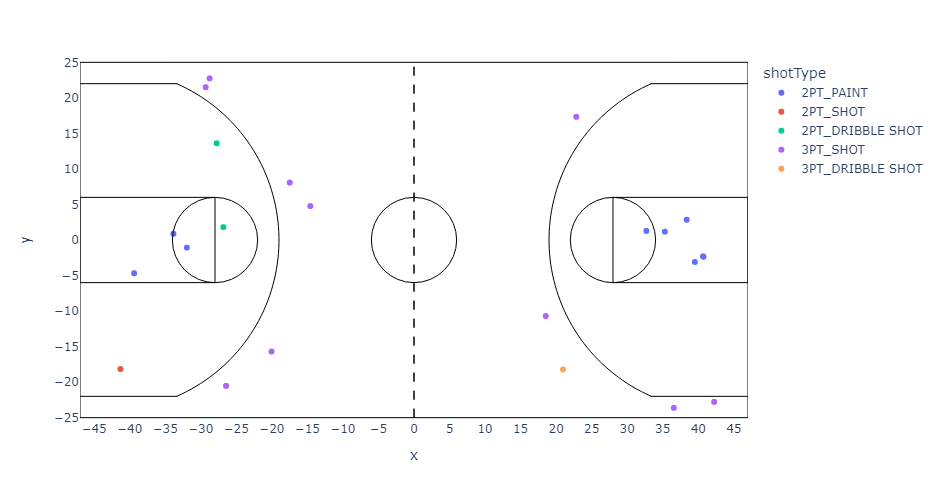

In [95]:
# Plot Jalen's shot in the game example
basketball_court_layout = get_layout()
shotType_order = ['2PT_PAINT', '2PT_SHOT', '2PT_DRIBBLE SHOT', '3PT_SHOT', '3PT_DRIBBLE SHOT']
fig = px.scatter(Jaylen_merge_all, x = 'x', y = 'y', color='shotType', category_orders = {'shotType': shotType_order})
fig.update_layout(basketball_court_layout)

pio.write_image(fig, '../imgs/Jaylen_1.png', width=940, height=500)
display(Image(filename = '../imgs/Jaylen_1.png'))

In [96]:
# Get Jaylen's shots in all 18 games and plot it
Jaylen_all = pd.DataFrame()

for game in Jaylen_game_ids:
    Jaylen_shots_pbp = getpbp.get_shot(game, 'Jaylen Brown')
    Jaylen_shots_pbp['ACTIONTYPE'] = Jaylen_shots_pbp['HOMEDESCRIPTION'].apply(
        lambda x: '3PT' if ' 3PT ' in x else '2PT')
    Jaylen_event = get_event(game, Jaylen_id)
    Jaylen_merge = pd.merge(Jaylen_shots_pbp, Jaylen_event, left_on = 'EVENTNUM',
                        right_on = 'pbpId', how = 'left')
    Jaylen_xy = gd.get_xy_df(game, Jaylen_id)
    Jaylen_merge = pd.merge(Jaylen_merge, Jaylen_xy, on = ['gameClock', 'period'], how = 'left')
    Jaylen_tracking = get_tracking_shots(game, Jaylen_merge)
    Jaylen_merge = pd.merge(Jaylen_merge, Jaylen_tracking[['gameClock','period', 'awayPlayers']], 
                        on = ['gameClock', 'period'], how = 'left')
    Jaylen_merge_dist = get_distance(Jaylen_merge)
    
    Jaylen_all = pd.concat([Jaylen_all, Jaylen_merge_dist], ignore_index = True)
print(Jaylen_all.shape)

(111, 13)


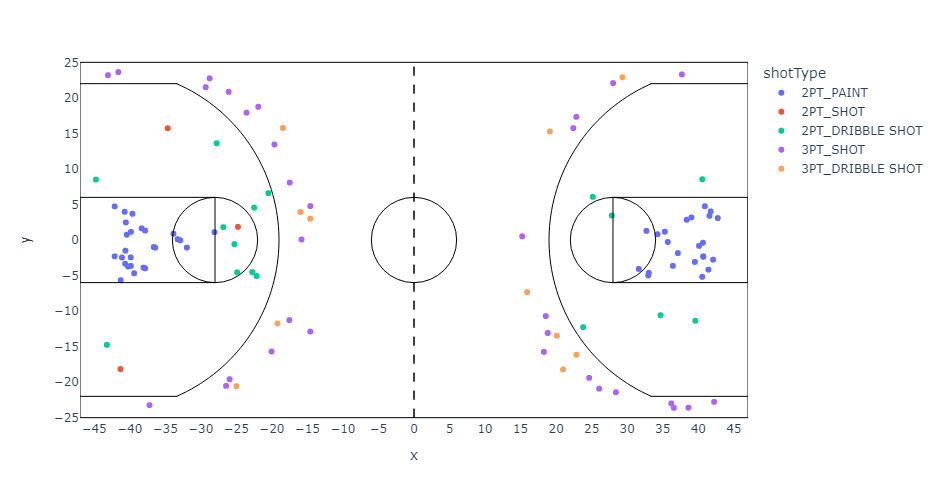

In [97]:
basketball_court_layout = get_layout()
shotType_order = ['2PT_PAINT', '2PT_SHOT', '2PT_DRIBBLE SHOT', '3PT_SHOT', '3PT_DRIBBLE SHOT']
fig = px.scatter(Jaylen_all, x = 'x', y = 'y', color='shotType', category_orders = {'shotType': shotType_order})
fig.update_layout(basketball_court_layout)

pio.write_image(fig, '../imgs/Jaylen_all.png', width=940, height=500)
display(Image(filename = '../imgs/Jaylen_all.png'))

In [98]:
def get_shots_home(player_id):
    '''
    Combine all process shown above, loop through game_ids to generate a dataframe of all shots done by 
    a player as part of home team
    
    Args: player_id(str)
    Return dataframe
    '''
    game_ids = [key for key, value in home_player_dict.items() if player_id in value]
    merge_all = pd.DataFrame()
    for game in game_ids:
        player_name = gd.get_playerInfo(player_id, 'id', 'fullName')
        shots_pbp = getpbp.get_shot(game, player_name)
        if shots_pbp.empty:
            continue
        shots_pbp['ACTIONTYPE'] = shots_pbp['HOMEDESCRIPTION'].apply(
            lambda x: '3PT' if ' 3PT ' in x else '2PT')
        event = get_event(game, player_id)
        merge = pd.merge(shots_pbp, event, left_on = 'EVENTNUM',
                            right_on = 'pbpId', how = 'left')
        xy = gd.get_xy_df(game, player_id)
        merge = pd.merge(merge, xy, on = ['gameClock', 'period'], how = 'left')
        
        tracking = get_tracking_shots(game, merge)
        merge = pd.merge(merge, tracking[['gameClock','period', 'awayPlayers']], 
                            on = ['gameClock', 'period'], how = 'left')
        merge_dist = get_distance(merge)
        merge_dist['game_id'] = game

        merge_all = pd.concat([merge_all, merge_dist], ignore_index = True)      
        
    return merge_all

In [99]:
def get_shots_away(player_id):
    '''
    Combine all process shown above, loop through game_ids to generate a dataframe of all shots done by 
    a player as part of away team
    
    Args: player_id(str)
    Return dataframe
    '''
    game_ids = [key for key, value in away_player_dict.items() if player_id in value]
    merge_all = pd.DataFrame()
    for game in game_ids:
        player_name = gd.get_playerInfo(player_id, 'id', 'fullName')
        shots_pbp = getpbp.get_shot(game, player_name)
        if shots_pbp.empty:
            continue
        shots_pbp['ACTIONTYPE'] = shots_pbp['VISITORDESCRIPTION'].apply(
            lambda x: '3PT' if ' 3PT ' in x else '2PT')
        event = get_event(game, player_id)
        merge = pd.merge(shots_pbp, event, left_on = 'EVENTNUM',
                            right_on = 'pbpId', how = 'left')
        xy = gd.get_xy_df(game, player_id, home = False)
        merge = pd.merge(merge, xy, on = ['gameClock', 'period'], how = 'left')
        
        tracking = get_tracking_shots(game, merge)
        merge = pd.merge(merge, tracking[['gameClock','period', 'homePlayers']], 
                            on = ['gameClock', 'period'], how = 'left')
        merge_dist = get_distance(merge, home = False)
        merge_dist['game_id'] = str(game)
        
        merge_all = pd.concat([merge_all, merge_dist], ignore_index = True)
               
    return merge_all

In [100]:
# Get shots info for all home players

#start_time = datetime.datetime.now()

home_player_shots = pd.DataFrame()
for player_id in list(home_player_ids):
    player_shots = get_shots_home(player_id)
    player_shots['height'] = gd.get_playerInfo(player_id, 'id', 'height')
    player_shots['name'] = gd.get_playerInfo(player_id, 'id', 'fullName')
    player_shots['position'] = gd.get_playerInfo(player_id, 'id', 'position')
    home_player_shots = pd.concat([home_player_shots, player_shots], ignore_index = True)
    #print(player_id)

#end_time = datetime.datetime.now()
#elapsed_time = end_time - start_time
#print(f"Elapsed time: {elapsed_time}")

In [101]:
# Get shots info for all away players
away_player_shots = pd.DataFrame()
for player_id in list(away_player_ids):
    player_shots = get_shots_away(player_id)
    player_shots['height'] = gd.get_playerInfo(player_id, 'id', 'height')
    player_shots['name'] = gd.get_playerInfo(player_id, 'id', 'fullName')
    player_shots['position'] = gd.get_playerInfo(player_id, 'id', 'position')
    away_player_shots = pd.concat([away_player_shots, player_shots], ignore_index = True)
    #print(player_id)

In [102]:
# Combine homeplayers' shots and away players' shots
all_player_shots = pd.concat([home_player_shots.assign(HomeAway = 'home'), 
                             away_player_shots.assign(HomeAway = 'away')],ignore_index=True)

In [103]:
print(all_player_shots.shape)
all_player_shots.head()

(2984, 18)


,shotType,ACTIONTYPE,EVENTMSGTYPE,eventType,HOMEDESCRIPTION,VISITORDESCRIPTION,gameClock,shotClock,period,x,y,closest_opponent_player_id,closest_opponent_dist,game_id,height,name,position,HomeAway
0,3PT_DRIBBLE SHOT,3PT,score,DRIBBLE SHOT,Wiggins 25' 3PT Pullup Jump Shot (3 PTS) (Loon...,None,685.96,13.8,1.0,17.59,-6.24,79b83f96-5723-4219-b521-57de6111ee97,6.73,0042100402,79.0,Andrew Wiggins,F,home
1,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 3' Driving Layup,Horford BLOCK (1 BLK),547.64,14.4,1.0,40.82,-1.92,ff427c2e-89ef-11e6-8d2a-a45e60e298d3,1.51,0042100402,79.0,Andrew Wiggins,F,home
2,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 6' Driving Layup,None,375.60,15.1,1.0,39.46,3.16,a6904c1c-0dc5-41c8-a618-b3a276131726,3.98,0042100402,79.0,Andrew Wiggins,F,home
3,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 3' Driving Layup,None,669.76,15.0,2.0,41.43,-4.27,a6904c1c-0dc5-41c8-a618-b3a276131726,1.06,0042100402,79.0,Andrew Wiggins,F,home
4,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 6' Driving Finger Roll Layup,None,467.60,14.6,2.0,38.98,4.24,79b83f96-5723-4219-b521-57de6111ee97,3.26,0042100402,79.0,Andrew Wiggins,F,home


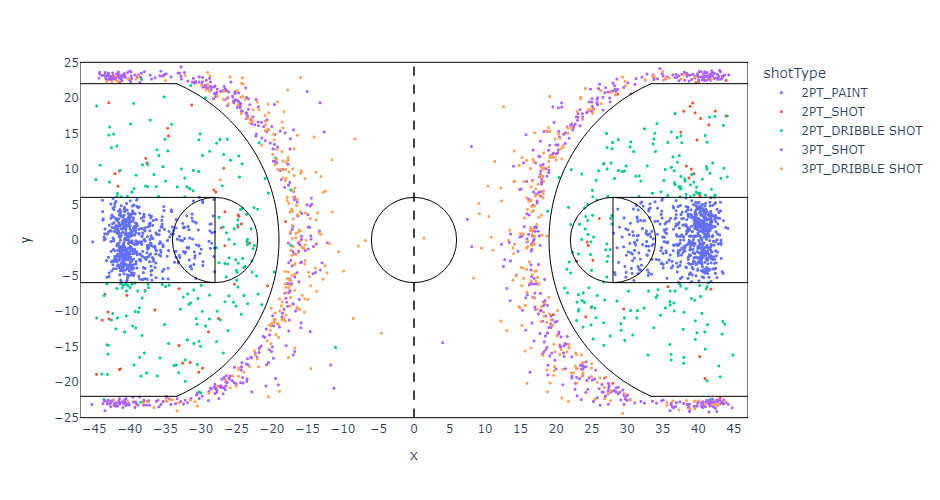

In [104]:
basketball_court_layout = get_layout()
shotType_order = ['2PT_PAINT', '2PT_SHOT', '2PT_DRIBBLE SHOT', '3PT_SHOT', '3PT_DRIBBLE SHOT']
fig = px.scatter(all_player_shots, x = 'x', y = 'y', color='shotType', category_orders = {'shotType': shotType_order})
fig.update_traces(marker=dict(size=3))
fig.update_layout(basketball_court_layout)

pio.write_image(fig, '../imgs/all_shots.png', width=940, height=500)
display(Image(filename = '../imgs/all_shots.png'))

In [105]:
all_player_shots.shape

(2984, 18)

In [106]:
# Check out one wrongly labeled dot in the plot
all_player_shots[(all_player_shots['x'] == -11.05) & (all_player_shots['y'] == -15.13)]
error_idx = all_player_shots[(all_player_shots['x'] == -11.05) & (all_player_shots['y'] == -15.13)].index
AW_id = gd.get_playerInfo('Andrew Wiggins', 'fullName', 'id')
get_shots_home(AW_id)
[key for key, value in home_player_dict.items() if AW_id in value]
AW_pbp = getpbp.get_shot('0042100312', 'Andrew Wiggins')
AW_pbp

,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION
0,10,2,102,MISS Wiggins 9' Driving Floating Bank Jump Shot,None
1,44,1,2,Wiggins 28' 3PT Running Jump Shot (3 PTS) (Cur...,None
2,57,2,1,MISS Wiggins 26' 3PT Jump Shot,None
3,87,1,9,Wiggins 3' Driving Dunk (5 PTS) (Porter Jr. 1 ...,None
4,124,2,75,MISS Wiggins 6' Driving Finger Roll Layup,None
5,126,2,97,MISS Wiggins Tip Layup Shot,None
6,131,1,101,Wiggins 9' Driving Floating Jump Shot (7 PTS) ...,None
7,259,2,75,MISS Wiggins 6' Driving Finger Roll Layup,Kleber BLOCK (1 BLK)
8,271,1,1,Wiggins 26' 3PT Jump Shot (10 PTS) (Thompson 2...,None
9,275,2,76,MISS Wiggins 4' Running Finger Roll Layup,None


In [107]:
# For timing reason, remove the dot for now
all_player_shots_2 = all_player_shots.drop(index = error_idx)

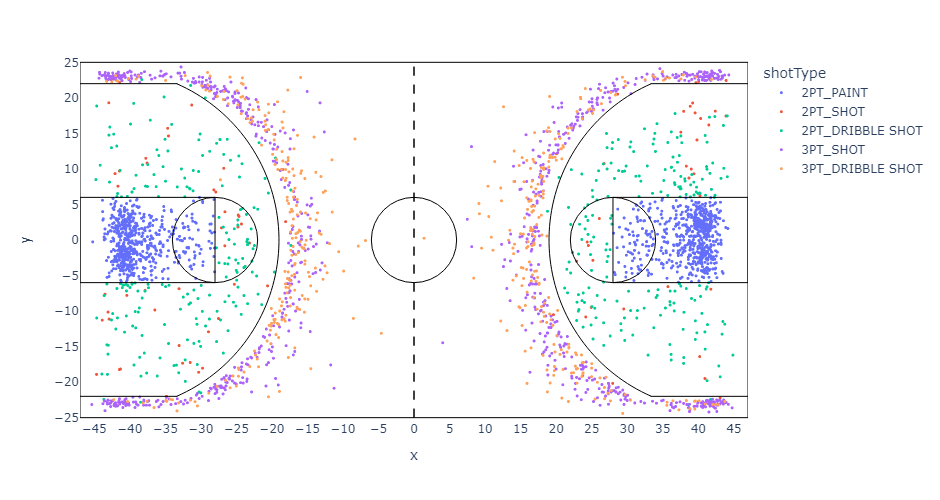

In [108]:
basketball_court_layout = get_layout()
shotType_order = ['2PT_PAINT', '2PT_SHOT', '2PT_DRIBBLE SHOT', '3PT_SHOT', '3PT_DRIBBLE SHOT']
fig = px.scatter(all_player_shots_2, x = 'x', y = 'y', color='shotType', category_orders = {'shotType': shotType_order})
fig.update_traces(marker=dict(size=3))
fig.update_layout(basketball_court_layout)

pio.write_image(fig, '../imgs/all_shots2.png', width=940, height=500)
display(Image(filename = '../imgs/all_shots2.png'))

- Add two features, 'opponent_importance' and 'opponent_height'

In [109]:
# Count the appearance frequency of 'closest opponent', assuming that player who appear more takes more important
# defence duty
name_counts = all_player_shots_2['closest_opponent_player_id'].value_counts()
all_player_shots_2['opponent_importance'] = (all_player_shots_2['closest_opponent_player_id'].map(
    name_counts)/len(all_player_shots_2)).round(4)

In [110]:
all_player_shots_2.rename(columns = {'EVENTMSGTYPE':'score_miss'}, inplace = True)

In [111]:
# Get the height of the closest opponent
all_player_shots_2['opponent_height'] = all_player_shots_2.apply(
    lambda row: gd.get_playerInfo(row['closest_opponent_player_id'], 'id', 'height'), axis = 1)

In [112]:
all_player_shots_2.drop(columns = ['closest_opponent_player_id'], inplace = True)

In [113]:
all_player_shots_2.head()

,shotType,ACTIONTYPE,score_miss,eventType,HOMEDESCRIPTION,VISITORDESCRIPTION,gameClock,shotClock,period,x,y,closest_opponent_dist,game_id,height,name,position,HomeAway,opponent_importance,opponent_height
0,3PT_DRIBBLE SHOT,3PT,score,DRIBBLE SHOT,Wiggins 25' 3PT Pullup Jump Shot (3 PTS) (Loon...,None,685.96,13.8,1.0,17.59,-6.24,6.73,0042100402,79.0,Andrew Wiggins,F,home,0.0409,81.0
1,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 3' Driving Layup,Horford BLOCK (1 BLK),547.64,14.4,1.0,40.82,-1.92,1.51,0042100402,79.0,Andrew Wiggins,F,home,0.0664,81.0
2,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 6' Driving Layup,None,375.60,15.1,1.0,39.46,3.16,3.98,0042100402,79.0,Andrew Wiggins,F,home,0.0489,78.0
3,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 3' Driving Layup,None,669.76,15.0,2.0,41.43,-4.27,1.06,0042100402,79.0,Andrew Wiggins,F,home,0.0489,78.0
4,2PT_PAINT,2PT,miss,DRIBBLE SHOT,MISS Wiggins 6' Driving Finger Roll Layup,None,467.60,14.6,2.0,38.98,4.24,3.26,0042100402,79.0,Andrew Wiggins,F,home,0.0409,81.0


In [114]:
#all_player_shots_2.to_csv('../new_data/all_player_shots.csv', index = False)